# Waze Analysis

# Imports

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix, classification_report
from sklearn.semi_supervised import LabelPropagation

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [82]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = Pipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = Pipeline(
    steps =[
      ("scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor,model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearnPipeline(steps=steps)

def create_sampling_pipeline(preprocessor, sampling_model, model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("sample", sampling_model),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(2, ("Feature Selection", kbest))
  
  return Pipeline(steps=steps)

# def find_best_label_propagation_model(complete_df, missing_values_df, preprocessor):
  
#     X_labeled = complete_df.drop("label", axis=1)
#     y_labeled = complete_df["label"]
  
#     encoder = LabelEncoder()
#     y_encoded = encoder.fit_transform(y_labeled)
  
#     X_unlabeled = missing_values_df.drop("label", axis=1)
    
#     X_combined = pd.concat([X_labeled, X_unlabeled], axis=0)
#     y_combined = pd.concat([pd.Series(y_encoded), pd.Series([-1] * len(X_unlabeled))])
    
#     label_propagation = LabelPropagation()
    
#     pipeline = create_sklearn_pipeline(preprocessor, label_propagation)
#     pipeline.fit(X_combined, y_combined)
    
#     pseudo_labels = pipeline.named_steps['model'].transduction_[len(X_labeled):]
#     X_unlabeled['pseudo_label'] = pseudo_labels
    
#     y_pred_test_decoded = encoder.inverse_transform(pseudo_labels)
    
#     return X_unlabeled

def find_best_label_propagation_model(complete_df, missing_values_df, preprocessor):
    X_labeled = complete_df.drop("label", axis=1)
    y_labeled = complete_df["label"]
    
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y_labeled)

    X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_encoded, test_size=0.3, random_state=42)

    X_unlabeled = missing_values_df.drop("label", axis=1)

    X_combined = pd.concat([X_train, X_unlabeled], axis=0)
    y_combined = pd.concat([pd.Series(y_train), pd.Series([-1] * len(X_unlabeled))])

    label_propagation = LabelPropagation()

    pipeline = create_sklearn_pipeline(preprocessor, label_propagation)

    pipeline.fit(X_combined, y_combined)
    
    pseudo_labels = pipeline.named_steps['model'].transduction_[len(X_train):]
    X_unlabeled['pseudo_label'] = pseudo_labels

    y_pred_test = pipeline.predict(X_test)

    y_test_decoded = encoder.inverse_transform(y_test)
    y_pred_test_decoded = encoder.inverse_transform(y_pred_test)


    print("Classification Report:")
    print(classification_report(y_test_decoded, y_pred_test_decoded))

    accuracy = accuracy_score(y_test_decoded, y_pred_test_decoded)
    print(f"Accuracy on Test Set: {accuracy:.2f}")

    return X_unlabeled, accuracy

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/waze_dataset.csv")
df

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,14994,retained,60,55,207.875622,140,317,0,2890.496901,2186.155708,25,17,iPhone
14995,14995,retained,42,35,187.670313,2505,15,10,4062.575194,1208.583193,25,20,Android
14996,14996,retained,273,219,422.017241,1873,17,0,3097.825028,1031.278706,18,17,iPhone
14997,14997,churned,149,120,180.524184,3150,45,0,4051.758549,254.187763,6,6,iPhone


In [4]:
df.drop("ID", axis=1, inplace=True)

# Check For Nulls / Dupes

In [5]:
check_for_nulls_dupes(df)

The amount of Null Values: label                      700
sessions                     0
drives                       0
total_sessions               0
n_days_after_onboarding      0
total_navigations_fav1       0
total_navigations_fav2       0
driven_km_drives             0
duration_minutes_drives      0
activity_days                0
driving_days                 0
device                       0
dtype: int64
The amount of Duplicated Values 0


# Check Class Imbalance

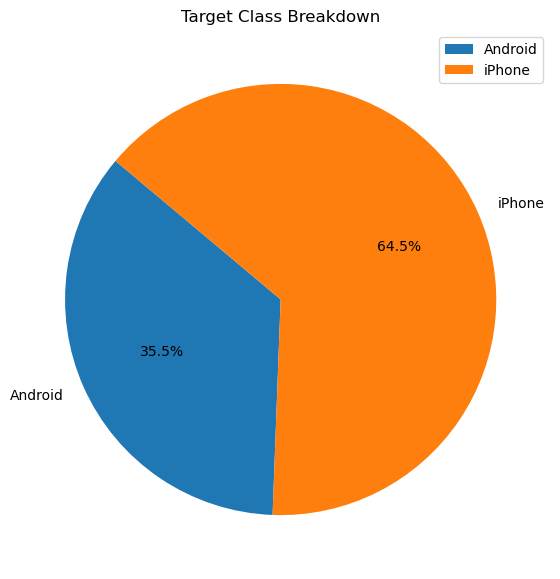

In [10]:
check_class_imbalance(df["device"])

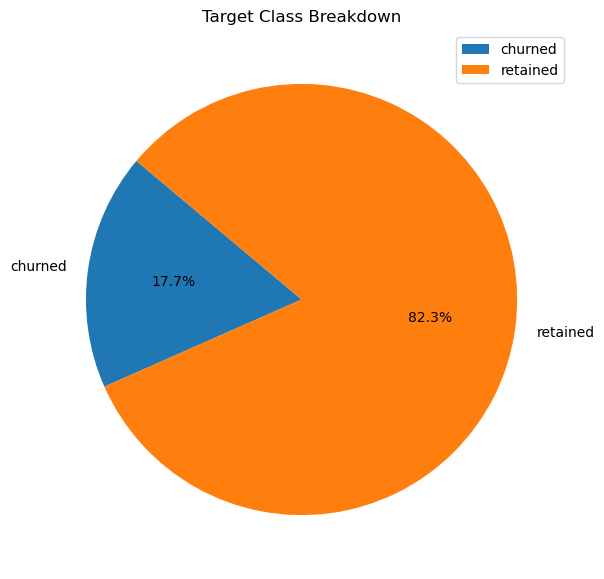

In [11]:
check_class_imbalance(df["label"].dropna())

# Create Preprocessor

In [6]:
numeric_types = df.select_dtypes(exclude="object")
categorical_types = df.select_dtypes(include="object").drop("label", axis=1)

preprocessor = create_column_transformer(categorical_types.columns, numeric_types.columns)
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 Index(['device'], dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['sessions', 'drives', 'total_sessions', 'n_days_after_onboarding',
       'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
       'duration_minutes_drives', 'activity_days', 'driving_days'],
      dtype='object'))])

# Imbalanced Dataset

In [7]:
missing_values = df[df.isna().any(axis=1)]

In [8]:
missing_values

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
77,NaN,63,50,133.104155,783,201,0,2649.015822,1517.209970,19,13,iPhone
80,NaN,116,93,436.060183,1584,283,62,4183.409514,3121.889952,18,15,iPhone
98,NaN,78,64,583.492789,3414,0,0,1811.140893,642.189122,12,11,Android
111,NaN,106,102,113.379056,2228,14,0,2817.481840,2011.724274,17,13,Android
142,NaN,32,26,222.129310,208,55,10,2459.816477,874.427617,11,7,iPhone
...,...,...,...,...,...,...,...,...,...,...,...,...
14941,NaN,191,160,485.328204,1287,25,0,6468.181924,3466.104564,14,14,iPhone
14943,NaN,48,38,96.797017,555,0,6,8266.129497,5902.351711,19,19,iPhone
14945,NaN,34,29,134.416604,1643,268,2,4554.007843,1579.211201,18,17,Android
14972,NaN,220,181,256.212166,1718,360,23,5586.913459,4104.440202,19,18,iPhone


# 700 Rows Are missing a target column. We could do an unsupervised learning model to cluster these values into the right buckets.

In [9]:
missing_values.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,80.837143,67.798571,198.483348,1709.295714,118.717143,30.371429,3935.967029,1795.123358,15.382857,12.125714
std,79.987440,65.271926,140.561715,1005.306562,156.308140,46.306984,2443.107121,1419.242246,8.772714,7.626373
min,0.000000,0.000000,5.582648,16.000000,0.000000,0.000000,290.119811,66.588493,0.000000,0.000000
25%,23.000000,20.000000,94.056340,869.000000,4.000000,0.000000,2119.344818,779.009271,8.000000,6.000000
50%,56.000000,47.500000,177.255925,1650.500000,62.500000,10.000000,3421.156721,1414.966279,15.000000,12.000000
75%,112.250000,94.000000,266.058022,2508.750000,169.250000,43.000000,5166.097373,2443.955404,23.000000,18.000000
max,556.000000,445.000000,1076.879741,3498.000000,1096.000000,352.000000,15135.391280,9746.253023,31.000000,30.000000


In [30]:
complete_df = df[df["label"].notna()]
complete_df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530
std,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


# Kmean Clustering Algorithm

In [63]:
predicted_values = find_best_label_propagation_model(complete_df, missing_values, preprocessor)

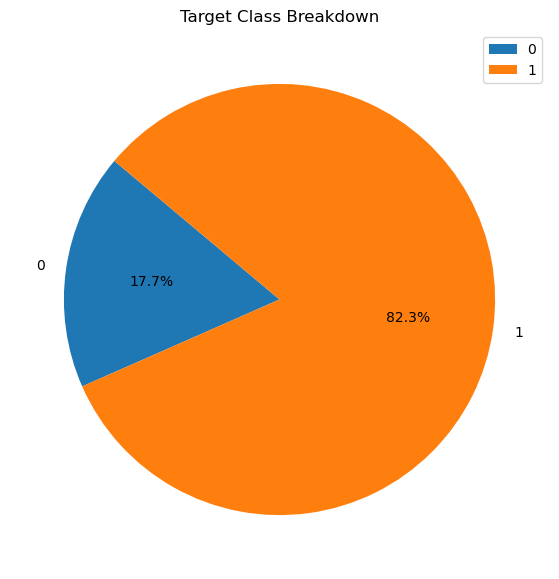

In [64]:
check_class_imbalance(predicted_values["pseudo_label"])

In [83]:
test, acc = find_best_label_propagation_model(complete_df, missing_values, preprocessor)

Classification Report:
              precision    recall  f1-score   support

     churned       0.29      0.27      0.28       783
    retained       0.84      0.85      0.84      3507

    accuracy                           0.74      4290
   macro avg       0.56      0.56      0.56      4290
weighted avg       0.74      0.74      0.74      4290

Accuracy on Test Set: 0.74
